# Exercise 5: Regularized Linear Regression and Bias vs. Variance

In this exercise, regularized linear regression is implemented to study models with different bias-variance properties.

Files provided by Coursera, located under `../exercises/ex1-ex8-octave/ex5`

- `ex5.m` - Octave/MATLAB script that steps you through the exercise
- `ex5data1.mat` - Dataset
- `submit.m` - Submission script that sends your solutions to our servers
- `featureNormalize.m` - Feature normalization function
- `fmincg.m` - Function minimization routine (similar to `fminunc`)
- `plotFit.m` - Plot a polynomial fit
- `trainLinearReg.m` - Trains linear regression using your cost function

Files to complete:

- `linearRegCostFunction.m` - Regularized linear regression cost function
- `learningCurve.m` - Generates a learning curve
- `polyFeatures.m` - Maps data into polynomial feature space
- `validationCurve.m` - Generates a cross validation curve

Workflow:

- Download latest Octave version of exercise from Coursera
- Complete code in exercise files following `ex5.pdf`
- Whenever an exercise part is finished
  - Check it with `ex5` in Octave terminal
  - Create a submission token on Coursera (exercise submission page, it lasts 30 minutes)
  - Execute `submit` in Octave terminal
  - Introduce email and token
  - Results appear

**Overview of contents:**

0. Setup: `gnuplot`
1. Dataset Loading & Visualization


## 0. Setup: `gnuplot`

In [14]:
graphics_toolkit ("gnuplot");

In [15]:
%plot -b inline:gnuplot

## 1. Dataset Loading & Visualization

In [16]:
% Load saved matrices from file
load('ex5data1.mat');

In [22]:
who

Variables visible from the current scope:

X      Xtest  Xval   ans    m      y      ytest  yval



In [24]:
size(X)

ans =

   12    1



In [26]:
size(y)

ans =

   12    1



In [18]:
m = size(X,1);

ans = -31.462


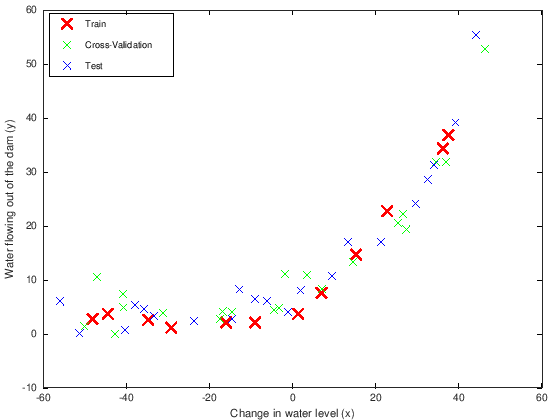

In [35]:
plot(X, y, 'rx', 'MarkerSize', 10, 'LineWidth', 5);
hold on;
plot(Xval, yval, 'gx', 'MarkerSize', 7, 'LineWidth', 1.5);
plot(Xtest, ytest, 'bx', 'MarkerSize', 7, 'LineWidth', 1.5);
legend('Train', 'Cross-Validation', 'Test','location','northwest')
xlabel('Change in water level (x)');
ylabel('Water flowing out of the dam (y)');

## 2. Regularized Linear Regression

### 2.1 Regularized Linear Regression: Cost Function & Gradient -- `linearRegCostFunction.m`

Cost function:

$$ J(\theta) = \frac{1}{2m} \left( \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right)^2 \right) + \frac{\lambda}{2m} \left( \sum_{j=1}^n \theta_j^2 \right)$$

Gradient:

$$
\begin{align}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} & \qquad \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \qquad \text{for } j \ge 1
\end{align}
$$



In [49]:
function [J, grad] = costFunction(X, y, theta, lambda)
    % Number of training examples
    m = length(y); 
    % Init return variables
    J = 0;
    grad = zeros(size(theta));
    
    % Cost (without regularization)
    h = X*theta; % (m x (n+1)) x ((n+1) x 1) -> m x 1
    e = (h - y); % m x 1
    J = (0.5/m) * (e'*e);
    % Regularization term
    t = theta(2:end,:); % n x 1
    J = J + ((0.5*lambda/m) * (t'*t));
    
    % Gradient (without regularization)
    grad = (1/m) * (e'*X); % (1 x m) x (m x (n+1)) -> 1 x (n+1)
    % Regularization term
    r = (lambda/m) * theta(2:end,1); % n x 1
    grad = grad' + [0; r];
    
    % Column vector
    grad = grad(:);
end


In [50]:
theta = ones(size(X,2)+1,1); % (n+1) x 1
Xp = [ones(size(X,1),1), X]; % m x (n+1)
lambda = 1;

In [51]:
[J, grad] = costFunction(Xp, y, theta, lambda);

In [52]:
J

J = 303.99


In [53]:
grad

grad =

   -15.303
   598.251



### 2.2 Train and Plot Fitted Line -- `trainLinearReg.m`

In [54]:
function [theta] = train(X, y, lambda)
    initial_theta = zeros(size(X, 2), 1); 
    % Create "short hand" for the cost function to be minimized
    costFunction = @(t) linearRegCostFunction(X, y, t, lambda);
    % Now, costFunction is a function that takes in only one argument
    options = optimset('MaxIter', 200, 'GradObj', 'on');
    % Minimize using fmincg
    theta = fmincg(costFunction, initial_theta, options);
end

In [55]:
lambda = 0;
[theta] = trainLinearReg([ones(m, 1) X], y, lambda);

Iteration     3 | Cost: 2.237391e+01


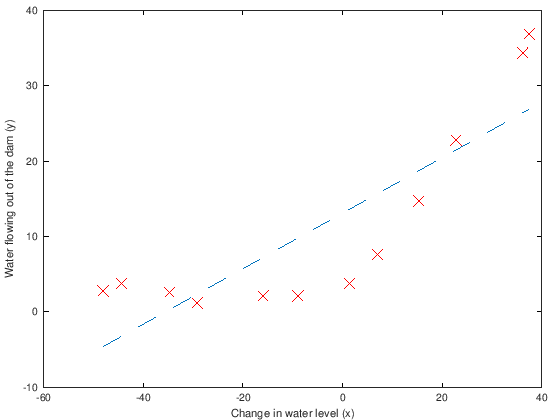

In [62]:
plot(X, y, 'rx', 'MarkerSize', 10, 'LineWidth', 1.5);
xlabel('Change in water level (x)');
ylabel('Water flowing out of the dam (y)');
hold on;
x = linspace(min(X(:)),max(X(:)),50)';
plot(x, [ones(size(x,1), 1) x]*theta, '--', 'LineWidth', 2)
hold off;

## 3. Bias-Variace

### 3.1 Learning Curves